In [10]:
import numpy as np
import resource
import time

## KNN

#### 1. Numpy

In [11]:
import numpy as np
import time
import resource
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.int64)

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=100, stratify=y, random_state=42)

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2, axis=1))

def knn_numpy(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test:
        distances = euclidean_distance(X_train, test_point)
        nearest = np.argsort(distances)[:k]
        nearest_labels = y_train[nearest]
        predictions.append(Counter(nearest_labels).most_common(1)[0][0])
    return np.array(predictions)

def print_peak_ram_usage():
    usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print(f"Peak RAM Usage: {usage / 1024:.2f} MB")

def test_bandwidth_numpy(X_train, X_test):
    start = time.time()
    _ = np.sum((X_train - X_test[0]) ** 2, axis=1)
    end = time.time()
    bytes_moved = (X_train.nbytes + X_test[0].nbytes) * 2
    bandwidth = bytes_moved / (end - start) / 1e9
    print(f"Estimated Memory Bandwidth: {bandwidth:.2f} GB/s")

start = time.time()
y_pred = knn_numpy(X_train, y_train, X_test)
end = time.time()
accuracy = np.mean(y_pred == y_test)

print(f"KNN-Numpy Accuracy (MNIST): {accuracy:.2f}")
print(f"Execution Time: {end - start:.4f} seconds")
print_peak_ram_usage()
test_bandwidth_numpy(X_train, X_test)

KNN-Numpy Accuracy (MNIST): 0.96
Execution Time: 0.1968 seconds
Peak RAM Usage: 2044.97 MB
Estimated Memory Bandwidth: 5.02 GB/s


#### 2. PyTorch

In [12]:
import torch
import time
import resource
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)

X = X / 255.0
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, train_size=1000, test_size=100, stratify=y, random_state=42)

device = "cpu"
X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.int64, device=device)

def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

def knn_torch(X_train, y_train, X_test, k=5):
    predictions = []
    for i in range(X_test.shape[0]):
        test_point = X_test[i]
        distances = euclidean_distance(X_train, test_point)
        nearest = torch.topk(distances, k=k, largest=False).indices
        nearest_labels = y_train[nearest]
        predicted = torch.mode(nearest_labels).values.item()
        predictions.append(predicted)
    return torch.tensor(predictions)

def print_peak_ram_usage():
    usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print(f"Peak RAM Usage: {usage / 1024:.2f} MB")

def test_bandwidth_torch(X_train, X_test):
    start = time.time()
    _ = torch.sum((X_train - X_test[0]) ** 2, dim=1)
    end = time.time()

    bytes_moved = (X_train.element_size() * X_train.nelement() +
                   X_test[0].element_size() * X_test[0].nelement()) * 2
    bandwidth = bytes_moved / (end - start) / 1e9
    print(f"Estimated Memory Bandwidth: {bandwidth:.2f} GB/s")

start = time.time()
y_pred = knn_torch(X_train, y_train, X_test, k=5)
end = time.time()

accuracy = (y_pred == y_test).float().mean().item()
print(f"KNN-PyTorch Accuracy (MNIST): {accuracy:.2f}")
print(f"Execution Time: {end - start:.4f} seconds")
print_peak_ram_usage()
test_bandwidth_torch(X_train, X_test)

KNN-PyTorch Accuracy (MNIST): 0.96
Execution Time: 0.1363 seconds
Peak RAM Usage: 2890.68 MB
Estimated Memory Bandwidth: 5.57 GB/s


#### 3. C/C++

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=100, stratify=y, random_state=42)

np.savetxt("X_train.csv", X_train, delimiter=",")
np.savetxt("y_train.csv", y_train, fmt='%d')
np.savetxt("X_test.csv", X_test, delimiter=",")
np.savetxt("y_test.csv", y_test, fmt='%d')

In [14]:
%%writefile knn_cpu.cpp
#include <iostream>
#include <vector>
#include <cmath>
#include <algorithm>
#include <map>
#include <chrono>
#include <fstream>
#include <sstream>
#include <sys/resource.h>

using namespace std;
using namespace std::chrono;

vector<vector<double>> load_csv_data(const string& filename, int rows, int cols) {
    vector<vector<double>> data(rows, vector<double>(cols));
    ifstream file(filename);
    string line;
    for (int i = 0; i < rows && getline(file, line); ++i) {
        stringstream ss(line);
        string val;
        for (int j = 0; j < cols && getline(ss, val, ','); ++j) {
            data[i][j] = stod(val);
        }
    }
    return data;
}

vector<int> load_csv_labels(const string& filename, int rows) {
    vector<int> labels(rows);
    ifstream file(filename);
    string line;
    for (int i = 0; i < rows && getline(file, line); ++i) {
        labels[i] = stoi(line);
    }
    return labels;
}

double euclidean_distance(const vector<double>& a, const vector<double>& b) {
    double sum = 0.0;
    for (size_t i = 0; i < a.size(); ++i) {
        double diff = a[i] - b[i];
        sum += diff * diff;
    }
    return sqrt(sum);
}

int knn_predict(const vector<vector<double>>& X_train, const vector<int>& y_train,
                const vector<double>& x_test, int k) {
    vector<pair<double, int>> distances;
    for (size_t i = 0; i < X_train.size(); ++i) {
        double dist = euclidean_distance(X_train[i], x_test);
        distances.push_back({dist, y_train[i]});
    }

    sort(distances.begin(), distances.end());

    map<int, int> class_count;
    for (int i = 0; i < k; ++i) {
        class_count[distances[i].second]++;
    }

    int prediction = -1, max_count = -1;
    for (const auto& pair : class_count) {
        if (pair.second > max_count) {
            max_count = pair.second;
            prediction = pair.first;
        }
    }
    return prediction;
}

void print_peak_ram_usage() {
    struct rusage usage;
    getrusage(RUSAGE_SELF, &usage);
    cout << "Peak RAM Usage: " << usage.ru_maxrss / 1024.0 << " MB" << endl;
}

double estimate_bandwidth(const vector<vector<double>>& X_train, const vector<double>& x_test) {
    auto start = high_resolution_clock::now();
    for (size_t i = 0; i < X_train.size(); ++i) {
        double sum = 0.0;
        for (size_t j = 0; j < x_test.size(); ++j) {
            double diff = X_train[i][j] - x_test[j];
            sum += diff * diff;
        }
        volatile double result = sqrt(sum);
    }
    auto end = high_resolution_clock::now();
    double elapsed = duration_cast<nanoseconds>(end - start).count() / 1e9;

    size_t bytes = X_train.size() * x_test.size() * sizeof(double) * 2;
    return bytes / elapsed / 1e9;
}

int main() {
    int num_train = 1000;
    int num_test = 100;
    int num_features = 784;
    int k = 5;

    vector<vector<double>> X_train = load_csv_data("X_train.csv", num_train, num_features);
    vector<int> y_train = load_csv_labels("y_train.csv", num_train);
    vector<vector<double>> X_test = load_csv_data("X_test.csv", num_test, num_features);
    vector<int> y_test = load_csv_labels("y_test.csv", num_test);

    vector<int> y_pred;
    auto start = high_resolution_clock::now();

    for (int i = 0; i < num_test; ++i) {
        int pred = knn_predict(X_train, y_train, X_test[i], k);
        y_pred.push_back(pred);
    }

    auto stop = high_resolution_clock::now();
    auto duration = duration_cast<milliseconds>(stop - start);
    int correct = 0;
    for (int i = 0; i < num_test; ++i) {
        if (y_pred[i] == y_test[i]) correct++;
    }

    cout << "KNN-C++ Accuracy (MNIST): " << static_cast<double>(correct) / num_test << endl;
    cout << "Execution Time: " << duration.count() << " ms" << endl;
    print_peak_ram_usage();
    double bandwidth = estimate_bandwidth(X_train, X_test[0]);
    cout << "Estimated Memory Bandwidth: " << bandwidth << " GB/s" << endl;

    return 0;
}

Writing knn_cpu.cpp


In [15]:
!g++ -O2 knn_cpu.cpp -o knn_cpu
!./knn_cpu

KNN-C++ Accuracy (MNIST): 0.96
Execution Time: 125 ms
Peak RAM Usage: 2896.07 MB
Estimated Memory Bandwidth: 10.7764 GB/s


## Image Preprocessing Pipelines

#### 1. Numpy

In [16]:
pip install opencv-python pillow psutil

In [17]:
pip install --upgrade pillow

Processed 2 images
Total Execution Time: 2.6469 seconds
Estimated Memory Bandwidth: 0.021 GB/s
Peak RAM Usage: 2058.66 MB


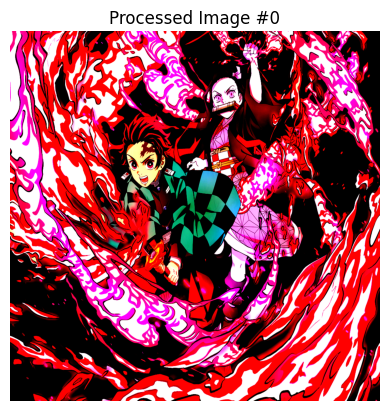

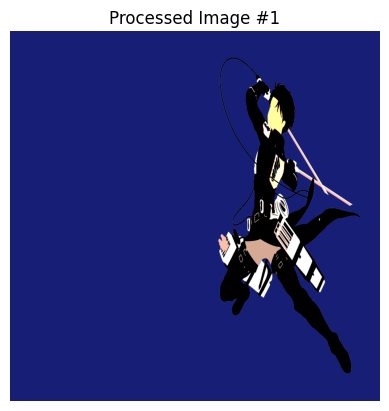

In [18]:
import cv2
import numpy as np
import os
import time
import psutil
from PIL import Image
import matplotlib.pyplot as plt

def print_peak_ram_usage():
    process = psutil.Process(os.getpid())
    print(f"Peak RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")

def preprocess_image(image_path, target_size=(1080,1080), to_gray=False):
    img = Image.open(image_path)

    if to_gray:
        img = img.convert("L")
    else:
        img = img.convert("RGB")

    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_np = np.asarray(img, dtype=np.float32) / 255.0

    mean = np.mean(img_np)
    std = np.std(img_np)
    img_np = (img_np - mean) / (std + 1e-8)

    return img_np

def run_pipeline_on_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files found.")
        return

    total_bytes = 0
    processed = []

    start = time.time()
    for f in image_files:
        img = preprocess_image(os.path.join(folder_path, f))
        processed.append(img)
        total_bytes += img.size * img.itemsize * 2
    end = time.time()

    elapsed = end - start
    bandwidth = total_bytes / elapsed / 1e9

    print(f"Processed {len(processed)} images")
    print(f"Total Execution Time: {elapsed:.4f} seconds")
    print(f"Estimated Memory Bandwidth: {bandwidth:.3f} GB/s")
    print_peak_ram_usage()

    for i, img in enumerate(processed[:2]):
        plt.figure()
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(f"Processed Image #{i}")
        plt.axis('off')
        plt.show()

    return None

folder = "/content/sample_data"
run_pipeline_on_folder(folder)

#### 2. PyTorch


Processed 2 images
Total Execution Time: 1.1354 seconds
Estimated Memory Bandwidth: 0.049 GB/s
Peak RAM Usage: 2058.92 MB


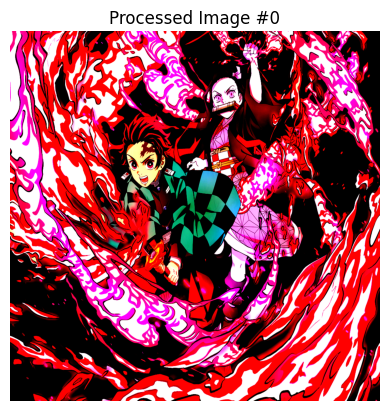

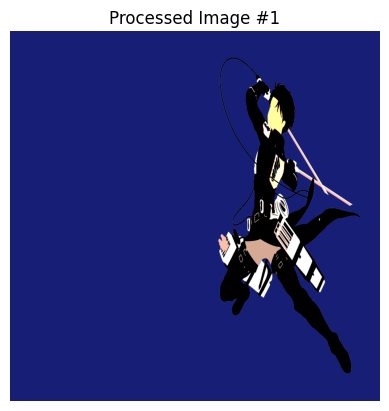

In [19]:
import os
import time
import torch
import psutil
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

warnings.filterwarnings("ignore")

def print_peak_ram_usage():
    process = psutil.Process(os.getpid())
    print(f"Peak RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")

def preprocess_image_torch(image_path, target_size=(1080, 1080), to_gray=False):
    img = Image.open(image_path)

    if to_gray:
        img = img.convert("L")
        transform = T.Compose([
            T.Resize(target_size, interpolation=T.InterpolationMode.LANCZOS),
            T.ToTensor(),
            T.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
        ])
    else:
        img = img.convert("RGB")
        transform = T.Compose([
            T.Resize(target_size, interpolation=T.InterpolationMode.LANCZOS),
            T.ToTensor(),
            T.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
        ])

    img_tensor = transform(img)
    return img_tensor

def run_pipeline_on_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files found.")
        return

    total_bytes = 0
    start = time.time()
    processed = []
    for f in image_files:
        tensor = preprocess_image_torch(os.path.join(folder_path, f))
        processed.append(tensor)
        total_bytes += tensor.numel() * tensor.element_size() * 2
    end = time.time()

    elapsed = end - start
    bandwidth = total_bytes / elapsed / 1e9

    print(f"\nProcessed {len(processed)} images")
    print(f"Total Execution Time: {elapsed:.4f} seconds")
    print(f"Estimated Memory Bandwidth: {bandwidth:.3f} GB/s")
    print_peak_ram_usage()

    for i, img_tensor in enumerate(processed[:2]):
        img_np = img_tensor.numpy()
        if img_np.shape[0] == 1:
            plt.imshow(img_np[0], cmap='gray')
        else:
            plt.imshow(img_np.transpose(1, 2, 0))
        plt.title(f"Processed Image #{i}")
        plt.axis('off')
        plt.show()

    return None

folder = "/content/sample_data"
run_pipeline_on_folder(folder)

#### 3. C++

In [20]:
!apt update && apt install -y libopencv-dev

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,675 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,939 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [21]:
%%writefile ipp_cpu.cpp
#include <iostream>
#include <filesystem>
#include <vector>
#include <string>
#include <chrono>
#include <opencv2/opencv.hpp>
#include <sys/resource.h>

namespace fs = std::filesystem;
using namespace std;
using namespace cv;
using namespace std::chrono;

void print_peak_ram_usage() {
    struct rusage usage;
    getrusage(RUSAGE_SELF, &usage);
    cout << "Peak RAM Usage: " << usage.ru_maxrss / 1024.0 << " MB" << endl;
}

Mat preprocess_image(const string& image_path, Size target_size, bool to_gray) {
    Mat img = imread(image_path, IMREAD_UNCHANGED);
    if (img.empty()) {
        cerr << "Could not read: " << image_path << endl;
        return Mat();
    }

    if (to_gray && img.channels() > 1)
        cvtColor(img, img, COLOR_BGR2GRAY);
    else if (!to_gray && img.channels() == 1)
        cvtColor(img, img, COLOR_GRAY2BGR);

    resize(img, img, target_size, 0, 0, INTER_LANCZOS4);
    img.convertTo(img, CV_32F, 1.0 / 255.0);

    Mat img_flat = img.reshape(1, img.total() * img.channels()); // Flatten to single column
    Scalar global_mean, global_std;
    meanStdDev(img_flat, global_mean, global_std);

    float mean_val = global_mean[0];
    float std_val = global_std[0];

    Mat standardized = (img - mean_val) / (std_val + 1e-8);


    return standardized;
}

void run_pipeline_on_folder(const string& folder_path, Size target_size = Size(1080, 1080), bool to_gray = false) {
    vector<Mat> processed_images;
    vector<size_t> image_bytes;
    int count = 0;

    auto start = high_resolution_clock::now();

    for (const auto& entry : fs::directory_iterator(folder_path)) {
        string ext = entry.path().extension().string();
        if (ext == ".jpg" || ext == ".png" || ext == ".jpeg") {
            Mat img = preprocess_image(entry.path().string(), target_size, to_gray);
            if (!img.empty()) {
                processed_images.push_back(img);
                image_bytes.push_back(img.total() * img.elemSize());
                count++;
            }
        }
    }

    auto end = high_resolution_clock::now();
    double elapsed = duration_cast<milliseconds>(end - start).count() / 1000.0;

    cout << "Processed " << count << " images" << endl;
    cout << "Total Execution Time: " << elapsed << " seconds" << endl;
    print_peak_ram_usage();

    for (int i = 0; i < min(2, count); ++i) {
        string win = "Processed Image #" + to_string(i);
        Mat display_img;
        processed_images[i].convertTo(display_img, CV_8UC3, 255.0);
        string out_path = "processed_" + to_string(i) + ".png";
        imwrite(out_path, display_img);
        cout << "Saved: " << out_path << endl;

    }

    size_t total_bytes = 0;
    for (auto b : image_bytes) total_bytes += b * 2;
    double bandwidth = total_bytes / elapsed / 1e9;
    cout << "Estimated Memory Bandwidth: " << bandwidth << " GB/s" << endl;
}

int main() {
    string folder = "/content/sample_data";
    run_pipeline_on_folder(folder, Size(1080, 1080), false);
    return 0;
}



Overwriting ipp_cpu.cpp


In [22]:
!g++ -std=c++17 ipp_cpu.cpp -o ipp_cpu `pkg-config --cflags --libs opencv4`
!./ipp_cpu

[ WARN:0] global ./modules/core/src/matrix_expressions.cpp (1333) assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739
libpng warning: iCCP: known incorrect sRGB profile
Processed 2 images
Total Execution Time: 0.433 seconds
Peak RAM Usage: 2896.07 MB
Saved: processed_0.png
Saved: processed_1.png
Estimated Memory Bandwidth: 0.129301 GB/s


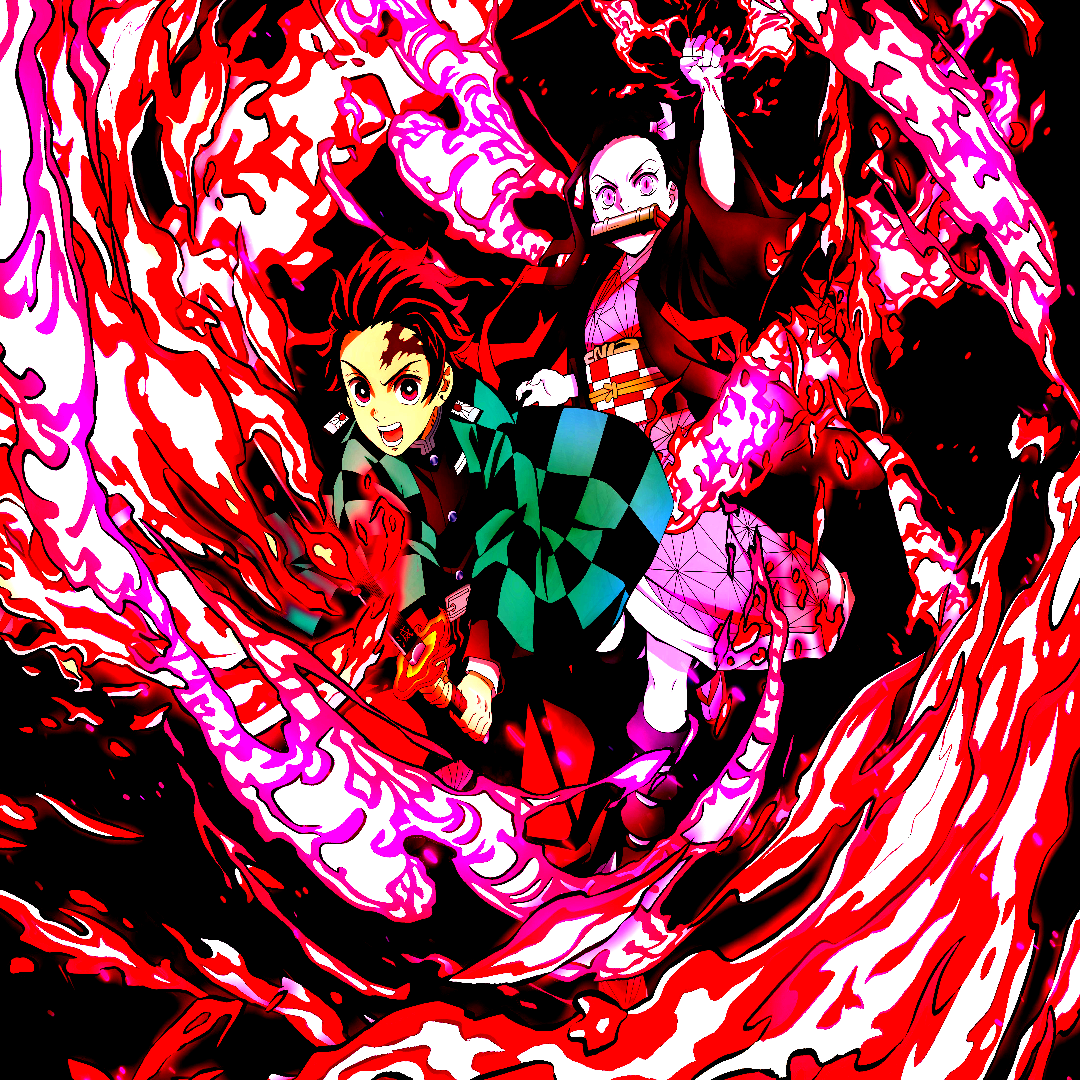

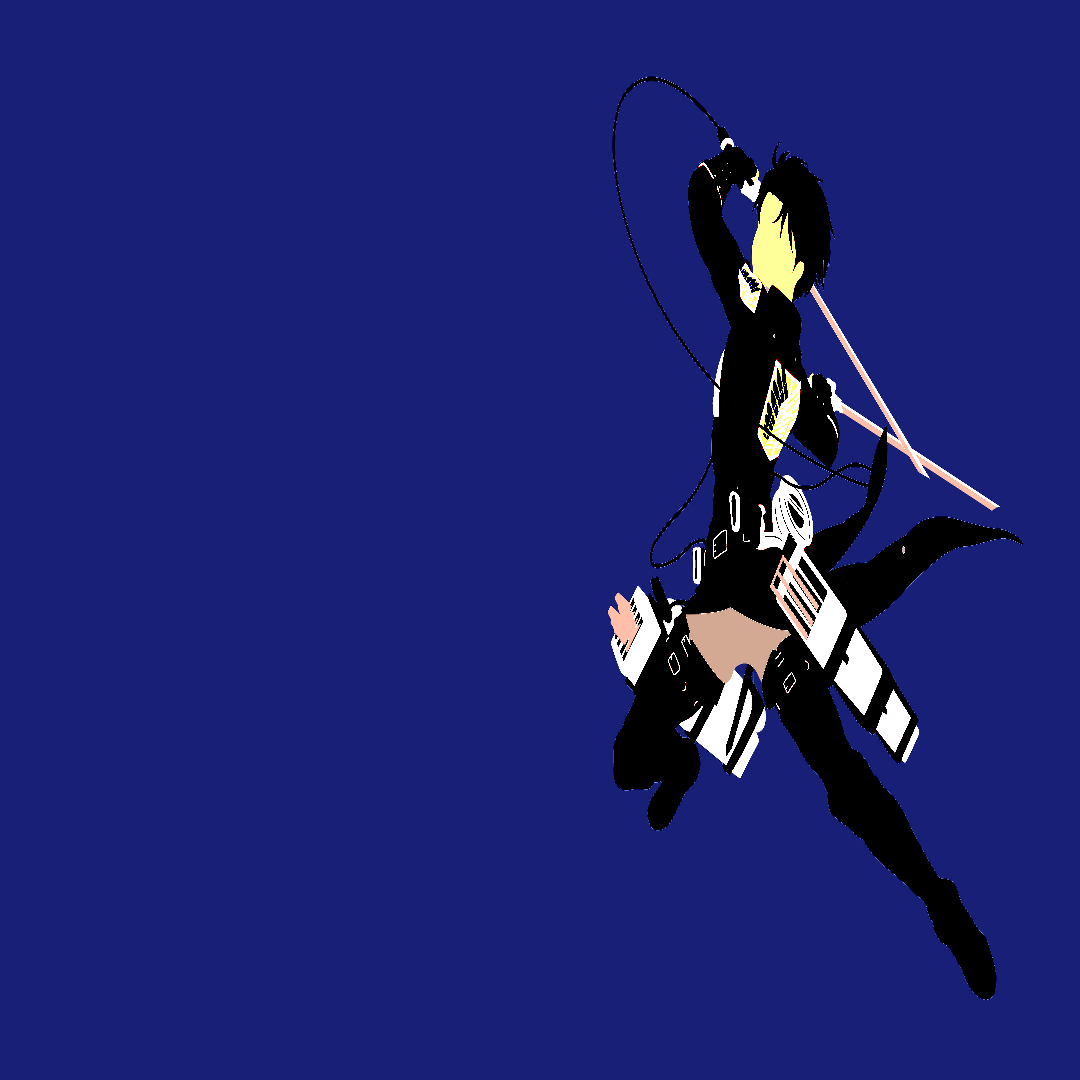

In [23]:
from IPython.display import Image, display

for i in range(2):
    fname = f"processed_{i}.png"
    display(Image(filename=fname, width=350, height=350))